# Imports

In [1]:
import os
import h5py
import sympy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math
from scipy.interpolate import CubicSpline

from tree import SVTree
from nodes import FunctionNode
from regressor import SVRegressor

# Setup

In [2]:
basePath = os.path.join('results', 'smeam_dup')
fromArchive = False

basePath = os.path.join('results', 'mo_smooth2')
fromArchive = True

In [3]:
choice = 0

if fromArchive:
    allTreeNames = glob.glob(os.path.join(basePath, '*'))
    del allTreeNames[allTreeNames.index(os.path.join(basePath, 'archive.pkl'))]
    
    bestCost = np.inf
    bestIdx = 0
    
    worstCost = 0
    worstIdx = 0
    
    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    
    allErrors = []
    allLatex = []

    for i, treePath in enumerate(allTreeNames):
        treeName = os.path.split(treePath)[-1]
        
        tree = pickle.load(open(os.path.join(treePath, 'tree.pkl'), 'rb'))

        entry = archive[treeName]
        tree.bestParams = entry.bestParams

        errors = entry.bestErrors
    
        latex = SVTree([
            FunctionNode(n.description) if isinstance(n, FunctionNode)
            else n
            for n in tree.nodes
        ]).latex()

        sumErrors = np.sum(errors)
        
        if sumErrors < bestCost:
            bestCost = sumErrors
            bestIdx = i
        
        if sumErrors > worstCost:
            worstCost = sumErrors
            worstIdx = i
        
        allErrors.append(sumErrors)
        allLatex.append(latex)
        
    allLatex = np.array(allLatex)[np.argsort(allErrors)]
    allTreeNames = np.array(allTreeNames)[np.argsort(allErrors)]
    allErrors = np.array(allErrors)[np.argsort(allErrors)]

    for latex, errors in zip(allLatex, allErrors):
        display(Math('{:.2f}<->{}'.format(
            errors,
            sympy.latex(sympy.sympify(latex, evaluate=False), mul_symbol='dot')
        )))
            
    treePath = allTreeNames[choice]
    treePath = allTreeNames[1]
    treeName = os.path.split(treePath)[-1]

    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    tree = pickle.load(open(os.path.join(basePath, treeName, 'tree.pkl'), 'rb'))
    
    entry = archive[treeName]
    tree.bestParams = entry.bestParams
    
    errors = entry.bestErrors
else:
    files = sorted(glob.glob(os.path.join(basePath, 'tree*')))
    intIndices = [int(s[s.find('tree')+5:s.find('.pkl')]) for s in files]

    argsort = np.argsort(intIndices)

    treeFile = np.array(files)[argsort][-1]
    tree = pickle.load(open(treeFile, 'rb'))
    
    errorFiles = sorted(glob.glob(os.path.join(basePath, 'errors*')))
    errorFile  = np.array(errorFiles)[argsort][-1]
    errors = pickle.load(open(errorFile, 'rb'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
treePath

'results/mo_smooth2/mul(ffg, ffg)'

# Plotting

In [29]:
def plotSpline(x, y, bc):
    cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
#     cs = CubicSpline(x, y, bc_type='natural')
    
    plotX = np.linspace(x[0]-.1, x[-1]+.1, 100)
    plotY = cs(plotX)
    
    return plotX, plotY

In [30]:
splits = []
types = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+len(svNode.restrictions[comp]))
        types.append(comp)

In [31]:
splitParams = np.array_split(tree.fillFixedKnots(tree.bestParams)[0], np.cumsum(splits)[:-1])

<IPython.core.display.Math object>

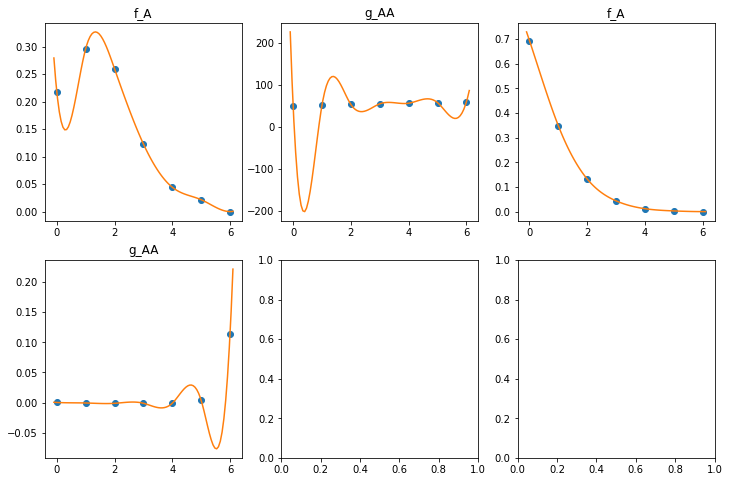

In [34]:
numRows = int(max(1, np.ceil(len(splitParams)/3)))

fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

compNames = np.hstack([svNode.components for svNode in tree.svNodes])

display(Math('{}'.format(
    sympy.latex(sympy.sympify(allLatex[choice], evaluate=False), mul_symbol='dot')
)))
    
for i, spline in enumerate(splitParams):
    y, bc = spline[:-2], spline[-2:]
    
    x = np.arange(len(y))
    
    plotX, plotY = plotSpline(x, y, bc)
    
    row = i//3
    col = i%3
    
    if numRows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
    
    ax.plot(x, y, 'o')
    ax.plot(plotX, plotY)
    ax.set_title(compNames[i].decode('utf-8'))
    
# _ = plt.suptitle(r'${}$'.format(sympy.latex(sympy.sympify(allLatex[choice], evaluate=False), mul_symbol='dot')))

In [33]:
splitParams[2]

array([ 0.69400443,  0.34843976,  0.13220814,  0.04362019,  0.01183334,
        0.00279363,  0.        , -0.35311995,  0.        ])

# Errors

## Directly from logs

In [53]:
energyWeight = 1
forcesWeight = 1

unweighted = errors.copy()
unweighted[::2] /= energyWeight
unweighted[1::2] /= forcesWeight

np.sqrt(np.average(unweighted**2))

0.23699244422719676

In [54]:
with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
        
    print(
        '{:>45} average errors || {:.6f} {:.6f}\n'.format(
            str(tree),
            np.sqrt(np.average(unweighted[::2]**2)),
            np.sqrt(np.average(unweighted[1::2]**2)),
        )
    )
    
    print(
        '{:>60} || {} {}'.format(
            'structName',
            '(eV/atom)',
            '(eV/A)'
        )
    )
    
    for i, structName in enumerate(sorted(db)):
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                unweighted[2*i],
                unweighted[2*i+1]
            )
        )

            add(rho, add(ffg, mul(rho, ffg))) average errors || 0.011502 0.334961

                                                  structName || (eV/atom) (eV/A)
                                        Ground_state_crystal || 0.000000 0.014663
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.001451 0.012469
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.001806 0.015489
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.001430 0.023469
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.008387 0.028313
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.020667 0.045762
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.000958 0.012809
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.003137 0.015803
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.001466 0.013145
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.001829 0.017188
                

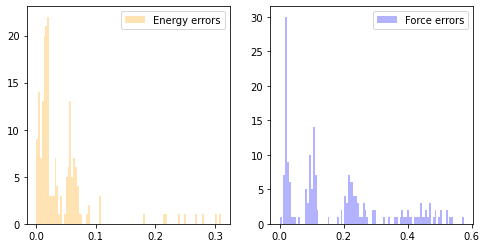

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(errors[::2] , bins=100, alpha=0.3, label='Energy errors', color='orange')
ax[1].hist(errors[1::2], bins=100, alpha=0.3, label='Force errors', color='blue')

ax[0].legend()
ax[1].legend()

## External validation

In [5]:
tree.bestParams.shape

(32,)

In [6]:
popDict = tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)

for svName in popDict:
    for bondType in popDict[svName]:
        popDict[svName][bondType] = [popDict[svName][bondType]]

In [7]:
def buildSVNodePool(group):
    """Prepare svNodePool for use in tree construction"""

    svNodePool = []

    # `group` is a pointer to an entry for a structure in the database
    for svName in sorted(group):
        svGroup = group[svName]

        restrictions = None
        if 'restrictions' in svGroup.attrs:
            restrictions = []
            resList = svGroup.attrs['restrictions'].tolist()
            for num in svGroup.attrs['numRestrictions']:
                tmp = []
                for _ in range(num):
                    tmp.append(tuple(resList.pop()))
                restrictions.append(tmp)

        svNodePool.append(
            SVNode(
                description=svName,
                components=svGroup.attrs['components'],
                numParams=svGroup.attrs['numParams'],
                bonds={
                    k:svGroup[k].attrs['components'] for k in svGroup.keys()
                },
                restrictions=restrictions,
                paramRanges=svGroup.attrs['paramRanges']\
                    if 'paramRanges' in group[svName].attrs else None
            )
        )

    return svNodePool

In [8]:
import cma

from mpi4py import MPI

from nodes import SVNode
from settings import Settings
from database import SVDatabase
from evaluator import SVEvaluator
from regressor import SVRegressor

settingsPath = 'examples/settings.in'
databasePath = '../svreg_data/mlearn/Mo/Mo.hdf5'

settings = Settings.from_file(settingsPath)
settings['PROCS_PER_PHYS_NODE'] = 1
settings['PROCS_PER_MANAGER'] = 1

worldComm = MPI.COMM_WORLD
with SVDatabase(settings['databasePath'], 'r') as database:
    structNames = list(database.keys())
    structNames = ['Ground_state_crystal']

    if settings['refStruct'] not in structNames:
        raise RuntimeError(
            "The reference structure must be included in structNames."
        )

    evaluator =  SVEvaluator(worldComm, structNames, settings)
    evaluator.distributeDatabase(database)

    trueValues = database.loadTrueValues()

#     numStructs = len(trueValues)
    
    refStruct = settings['refStruct']
    treeErrors = np.zeros(2*len(database))
    
    svNodePool = buildSVNodePool(database[settings['refStruct']])
    
    regressor = SVRegressor(
        settings, svNodePool, cma.CMAEvolutionStrategy, [1.0, {'popsize': 1}]
    )
    
    regressor.trees = [tree]
    
    treePopulations = [tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)]
    
    # Group all dictionaries into one
    populationDict = {}
    for svNode in svNodePool:
        populationDict[svNode.description] = {}
        for bondType in svNode.bonds:
            populationDict[svNode.description][bondType] = []

    for treeDict in treePopulations:
        for svName in treeDict.keys():
            for bondType, pop in treeDict[svName].items():
                populationDict[svName][bondType].append(pop)
                            
    svEng = evaluator.evaluate(populationDict, evalType='energy')
    svFcs = evaluator.evaluate(populationDict, evalType='forces')
    
    energies, forces = regressor.evaluateTrees(svEng, svFcs, 1)
    
    for structName in sorted(structNames):
        eng = energies[structName][0] - energies[refStruct][0]
        fcs =   forces[structName][0]
        
        engErrors = eng - trueValues[structName]['energy']
        fcsErrors = fcs - trueValues[structName]['forces']
        
        treeErrors[2*i]   = abs(engErrors)
        treeErrors[2*i+1] = np.average(np.abs(fcsErrors), axis=(1, 2))
        
        print(
            '{:>60} || {:.6f} {:.6f} ({:.6f})'.format(
                structName,
                treeErrors[2*i],
                treeErrors[2*i+1],
                energies[structName][0][0]
            )
        )
# del evaluator

tree.eval() intermediateEng: [-3766.25900969] [array([25562.98471245]), array([-0.14733252])]
                                        Ground_state_crystal || 0.000000 5.827250 (-3766.259010)


In [17]:
from scipy.special import erf

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


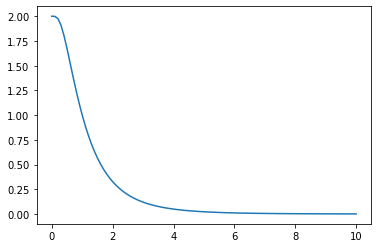

In [18]:
fig, ax = plt.subplots()

x = np.linspace(0, 10, 100)
ax.plot(x, 1-erf(np.log(x)))

In [19]:
1-erf(np.log(x))

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([2.00000000e+00, 1.99881362e+00, 1.97629491e+00, 1.90867730e+00,
       1.80002313e+00, 1.66597825e+00, 1.52118092e+00, 1.37600848e+00,
       1.23685949e+00, 1.10722126e+00, 9.88659792e-01, 8.81551842e-01,
       7.85579776e-01, 7.00050408e-01, 6.24093620e-01, 5.56782297e-01,
       4.97201968e-01, 4.44488927e-01, 3.97848925e-01, 3.56564155e-01,
       3.19993391e-01, 2.87568330e-01, 2.58787995e-01, 2.33212354e-01,
       2.10455803e-01, 1.90180917e-01, 1.72092635e-01, 1.55932998e-01,
       1.41476443e-01, 1.28525632e-01, 1.16907805e-01, 1.06471578e-01,
       9.70841656e-02, 8.86289679e-02, 8.10034728e-02, 7.41174426e-02,
       6.78913431e-02, 6.22549816e-02, 5.71463281e-02, 5.25104931e-02,
       4.82988410e-02, 4.44682204e-02, 4.09802950e-02, 3.78009622e-02,
       3.48998459e-02, 3.22498552e-02, 2.98267981e-02, 2.76090449e-02,
       2.55772333e-02, 2.37140095e-02, 2.20038018e-02, 2.04326211e-02,
       1.89878862e-02, 1.76582690e-02, 1.64335587e-02, 1.53045418e-02,
      

# Direct evaluation tests

In [13]:
str(tree)

'mul(ffg, ffg)'

In [14]:
import os
from ase.io import read

In [15]:
atoms = read('/home/jvita/scripts/s-meam/data/fitting_databases/mlearn/data/Mo/lammps/Ground_state_crystal.data', format='lammps-data', style='atomic')

In [16]:
y = tree.fillFixedKnots(tree.bestParams)[0]
y.shape

(36,)

In [9]:
tree.directEvaluation(y, atoms, evalType='energy') / len(atoms)

Summation.loop() totalEnergy: 25562.9847414047
Summation.loop() totalEnergy: -0.14733250678003182
intermediateEng: -3766.258622730858


-69.74553005057145

# Lattice constant tests

In [17]:
import ase.build
from ase.io import Trajectory, read, write

y = tree.fillFixedKnots(tree.bestParams)[0]

elements = ['Cu', 'Ge', 'Li' , 'Mo', 'Ni', 'Si']
crystals = ['fcc', 'diamond', 'bcc', 'bcc', 'fcc', 'diamond']

elem = 'Mo'

types = [elem]
cryst = crystals[elements.index(elem)]

atoms = ase.build.bulk(elem, cryst, cubic=True, a=3.4188376753507015)
traj = Trajectory("test.traj", 'w')

low = 2.5; high = 10

a_linspace = np.linspace(low, high, 100)
for a in a_linspace:
    scaled_atoms = atoms.copy()

    cell = scaled_atoms.get_cell()
    cell[0,0] = cell[1,1] = cell[2, 2,] = a

    scaled_atoms.set_cell(cell, scale_atoms=True)

    traj.write(scaled_atoms)

configs = ase.io.read("test.traj@:")

energies = [tree.directEvaluation(y, config, evalType='energy') / len(config) for config in configs]
a_trace = [config.cell[0,0] for config in configs]

Summation.loop() totalEnergy: 2950.798607382507
Summation.loop() totalEnergy: 0.09512396912124305
intermediateEng: 280.69167561166057
Summation.loop() totalEnergy: 2254.743742853751
Summation.loop() totalEnergy: 0.06074470131472899
intermediateEng: 136.9637352009052
Summation.loop() totalEnergy: 1816.329788795207
Summation.loop() totalEnergy: 0.036642367006122806
intermediateEng: 66.5546227251875
Summation.loop() totalEnergy: 1508.4293101708865
Summation.loop() totalEnergy: 0.019779920393902
intermediateEng: 29.836611675008644
Summation.loop() totalEnergy: 1260.7109004907084
Summation.loop() totalEnergy: 0.008053142559216913
intermediateEng: 10.152684607610402
Summation.loop() totalEnergy: 1087.4876992675618
Summation.loop() totalEnergy: 0.00034190773458545455
intermediateEng: 0.3718204556461201
Summation.loop() totalEnergy: 971.4394446982525
Summation.loop() totalEnergy: -0.004094713378975733
intermediateEng: -3.977766091070692
Summation.loop() totalEnergy: 919.0726496679172
Summation

Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() totalEnergy: 0.0
intermediateEng: 0.0
Summation.loop() totalEnergy: 0.0
Summation.loop() tota

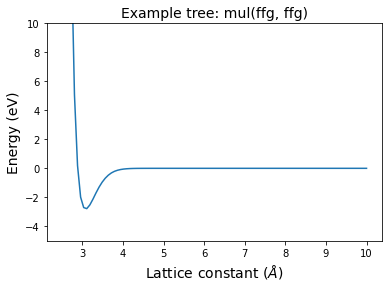

In [28]:
fig, ax = plt.subplots()

ax.plot(a_trace, energies)

ax.set_ylim([-5, 10])
ax.set_xlabel(r"Lattice constant ($\AA$)", fontsize=14)
ax.set_ylabel("Energy (eV)", fontsize=14)
ax.set_title("Example tree: {}".format(tree), fontsize=14)
print()

In [21]:
min_idx = np.argmin(energies)

min_a = a_trace[min_idx]

expected_a = [3.621, 5.763, 3.427, 3.168, 3.508, 5.469]

err = (min_a - expected_a[elements.index(elem)])/expected_a[elements.index(elem)]

print(expected_a[elements.index(elem)], min_a, err)

3.168 3.106060606060606 -0.019551576369758263
